# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código. De modo que si se consigue forzar el overfitting, entonces se puede congraciar que el modelo de difusión está bien implementado.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import random
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-14 19:49:09.578158: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 19:49:09.606756: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 19:49:10.825973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 19:49:10.829577: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"] = 32
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"] = 64
EPOCHS = hyperparameters["epochs"] = 100
TIMESTEPS = hyperparameters["timesteps"] = 500
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-06-14 19:49:15.034935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


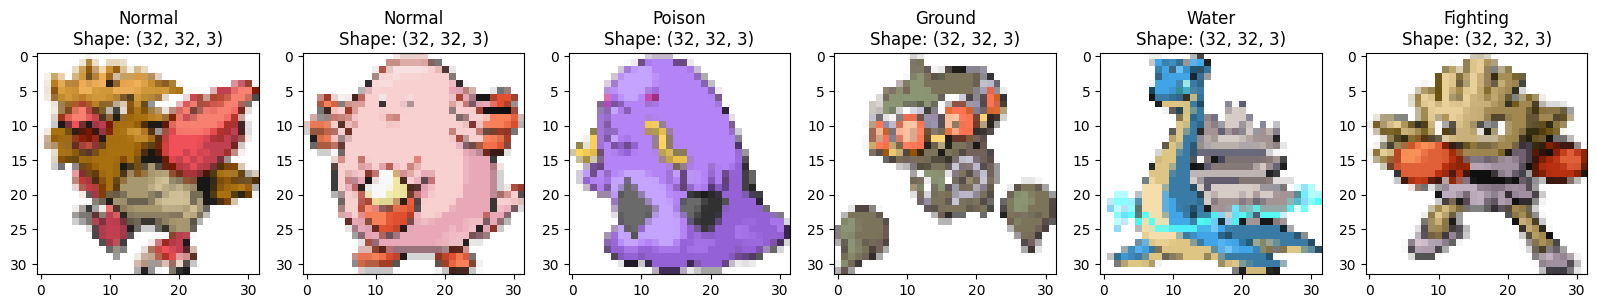

2024-06-14 19:49:15.956889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 32, 32, 3)
(64, 18)


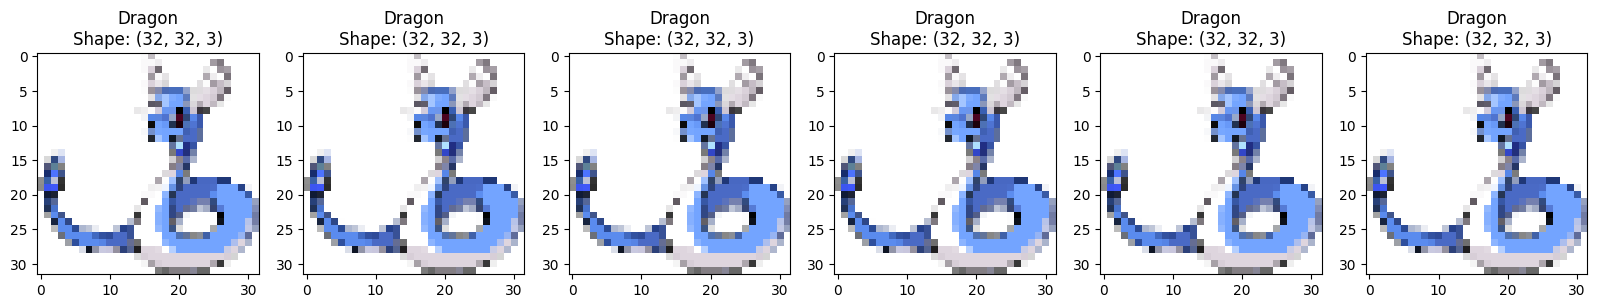

2024-06-14 19:51:45.296967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 19:51:45.298116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
# get one batch of the dataset
dataset_example = poke_dataset.take(len(poke_dataset))

# get one specific image of the batch
for img, label in dataset_example:
    random_index = random.randint(0, len(poke_dataset) - 1)
    img_example = img[random_index]
    label_example = label[random_index]
    break

# expand the items to the batch size
img_example = np.expand_dims(img_example, axis=0)
label_example = np.expand_dims(label_example, axis=0)

dataset_overfitting = tf.data.Dataset.from_tensor_slices((img_example, label_example))

n_images = len(poke_dataset) * BATCH_SIZE
dataset_overfitting = dataset_overfitting.repeat(n_images).batch(BATCH_SIZE)

for img, label in dataset_overfitting:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_overfitting.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_overfitting)

In [22]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

Epoch 1/100


I0000 00:00:1718394735.864996   10752 service.cc:145] XLA service 0x790cec018370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718394735.865027   10752 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-14 19:52:16.287838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718394736.673532   10752 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
W0000 00:00:1718394736.760211   10752 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1
2024-06-14 19:52:17.804

 1/63 ━━━━━━━━━━━━━━━━━━━━ 37:45 37s/step - mae: 1.2280 - loss: 2.3932

I0000 00:00:1718394760.590516   10752 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - mae: 0.8780 - loss: 1.2818
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - mae: 0.5463 - loss: 0.5015
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - mae: 0.4126 - loss: 0.3101
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.3571 - loss: 0.2445
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.3161 - loss: 0.1971
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2978 - loss: 0.1814
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2653 - loss: 0.1476
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2418 - loss: 0.1253
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2230 - loss: 0.1071
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2073 - loss: 0.0946
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1947 - loss: 0.0841
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1912 - loss: 0.0823
Epoch 13/100
63/63 ━━━━━━━━

Sampling sprite...: 100%|██████████| 499/499 [00:44<00:00, 11.33it/s]


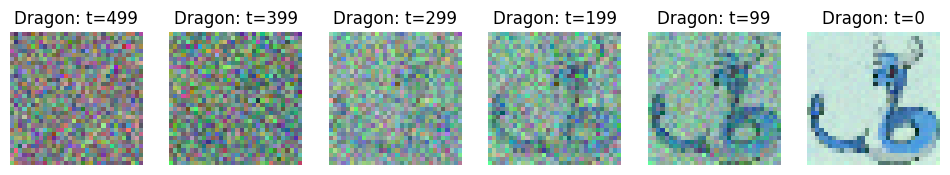

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 819ms/step - mae: 0.1288 - loss: 0.0380
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - mae: 0.1247 - loss: 0.0354
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1182 - loss: 0.0312
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1191 - loss: 0.0339
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1115 - loss: 0.0276
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1121 - loss: 0.0290
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1160 - loss: 0.0337
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1095 - loss: 0.0285
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1080 - loss: 0.0276
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0988 - loss: 0.0221
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0987 - loss: 0.0228
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.1008 - loss: 0.0243
Epoch 32/100
63/6

Sampling sprite...: 100%|██████████| 499/499 [00:43<00:00, 11.38it/s]


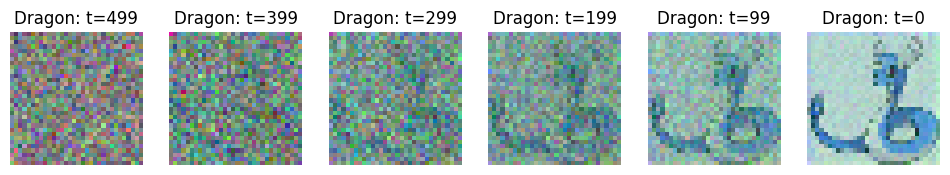

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 816ms/step - mae: 0.0855 - loss: 0.0176
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - mae: 0.0798 - loss: 0.0149
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0897 - loss: 0.0210
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0800 - loss: 0.0151
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0816 - loss: 0.0160
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0743 - loss: 0.0127
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0758 - loss: 0.0132
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0756 - loss: 0.0134
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0781 - loss: 0.0147
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0759 - loss: 0.0151
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0841 - loss: 0.0173
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0716 - loss: 0.0131
Epoch 52/100
63/6

Sampling sprite...: 100%|██████████| 499/499 [00:43<00:00, 11.37it/s]


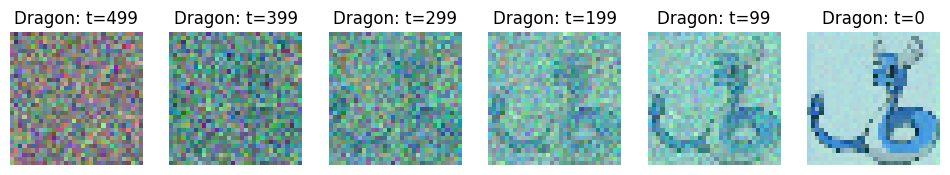

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 816ms/step - mae: 0.0694 - loss: 0.0127
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0639 - loss: 0.0103
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0660 - loss: 0.0106
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0661 - loss: 0.0103
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0732 - loss: 0.0145
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0631 - loss: 0.0097
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0632 - loss: 0.0101
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0621 - loss: 0.0095
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0636 - loss: 0.0104
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0631 - loss: 0.0098
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0672 - loss: 0.0111
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0629 - loss: 0.0104
Epoch 72/100
63/

Sampling sprite...: 100%|██████████| 499/499 [00:43<00:00, 11.35it/s]


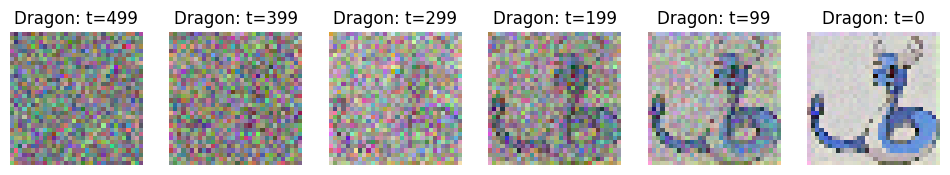

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 818ms/step - mae: 0.0583 - loss: 0.0080
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - mae: 0.0595 - loss: 0.0087
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0563 - loss: 0.0077
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0649 - loss: 0.0099
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0650 - loss: 0.0114
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0561 - loss: 0.0075
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0572 - loss: 0.0083
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0561 - loss: 0.0077
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0620 - loss: 0.0103
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0588 - loss: 0.0092
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0543 - loss: 0.0072
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.0706 - loss: 0.0137
Epoch 92/100
63/6

Sampling sprite...: 100%|██████████| 499/499 [00:44<00:00, 11.33it/s]


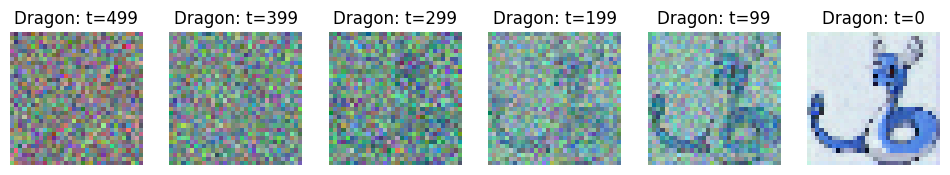

63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 829ms/step - mae: 0.0564 - loss: 0.0085


In [23]:
diff_callback = DiffusionCallback(model, 20, onehot_to_string(label_example))
model.fit(dataset_overfitting, epochs=EPOCHS, callbacks=[diff_callback])

Generating sample 1/6


Sampling sprite...: 100%|██████████| 499/499 [00:42<00:00, 11.82it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 499/499 [00:42<00:00, 11.63it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 499/499 [00:41<00:00, 12.17it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 499/499 [00:41<00:00, 12.09it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 499/499 [00:41<00:00, 11.94it/s]


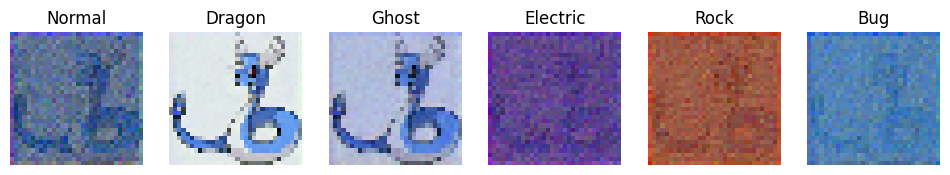

In [24]:
model.plot_samples(6)

Generating sample 1/1


Sampling sprite...: 100%|██████████| 499/499 [00:41<00:00, 11.95it/s]


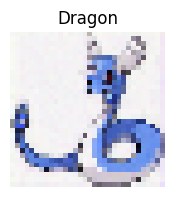

In [25]:
model.plot_samples(1, onehot_to_string(label_example))